### IV.	Predictive Analytics: Modeling & Prediction

####  <font color=blue>1. Import python libraries and cleaned data file

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import squarify
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import datetime
import time
import random
import os
import warnings
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20, 10)

#magic panda line that renders the figure in a notebook
%matplotlib inline

In [2]:
#import file
flights_FINAL=pd.read_csv("/Users/iulialaptop/Documents/0. Career/Python_Projects_Springboard/2015 Flight Delays and Cancellations/Data set/flights_FINAL.csv", low_memory=False)

#drop a few columns I know I will not use
flights_FINAL=flights_FINAL.drop(columns=['YEAR','LATITUDE_org', 'LONGITUDE_org','LATITUDE_dst','LONGITUDE_dst','COUNTRY_org','COUNTRY_dst'])

####  <font color=blue>2. Departure Delays - ALL data

##### Define dataframe for departure delays (>15 minutes)

In [3]:
#format Pandas scientific notation for floats
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
#drop columns not needed
flights_2=flights_FINAL.drop(columns=['DIVERTED','CANCELLED','CANCELLATION_REASON'])
#create a df with departure delays >15' (only such delays have an associated reason)
flights_DD=flights_2[flights_2['DEPARTURE_DELAY']>15]

In [5]:
#dropping rows with null values; delay reasons are reproted for the delays >15' only
flights_DD=flights_DD.dropna(subset=['AIRLINE_DELAY'])
flights_DD.isnull().sum()

MONTH                  0
DAY                    0
DAY_OF_WEEK            0
ARL_CODE               0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
Date                   0
Day_name               0
Month_name             0
ORG_ARP_FINAL          0
DST_ARP_FINAL          0
ARL_Name               0
ARP_CODE_org           0
ARP_Name_org           0
CITY_org               0
STATE_org              0
ARP_CODE_dst           0
ARP_Name_dst           0
CITY_dst               0
STATE_dst              0
dtype: int64

##### Understand the data distribution

In [6]:
#stats for the departure delays inclusing all data available
flights_DD['DEPARTURE_DELAY'].describe()

count   819621.00
mean        70.43
std         69.30
min         16.00
25%         31.00
50%         49.00
75%         85.00
max       1988.00
Name: DEPARTURE_DELAY, dtype: float64

<AxesSubplot:xlabel='DEPARTURE_DELAY'>

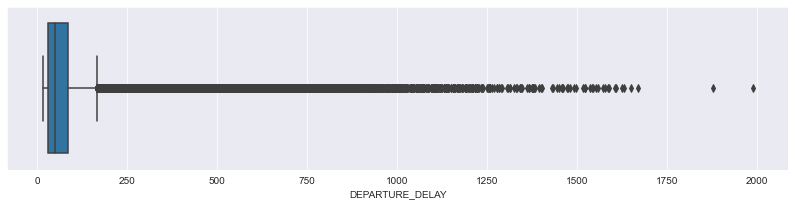

In [7]:
# display distribution as a boxplot
plt.figure(figsize=(14, 3))
sns.boxplot(x='DEPARTURE_DELAY', data=flights_DD)

<AxesSubplot:xlabel='DEPARTURE_DELAY', ylabel='Density'>

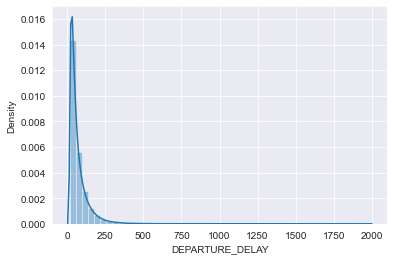

In [8]:
# standard distribution plot
sns.distplot(flights_DD['DEPARTURE_DELAY'])

In [9]:
# understand the upper tail of the distribution 
np.percentile(flights_DD.DEPARTURE_DELAY, [0.25,0.5,0.75,95,96,97,98,99,99.5])

array([ 16.,  16.,  16., 191., 208., 230., 264., 330., 411.])

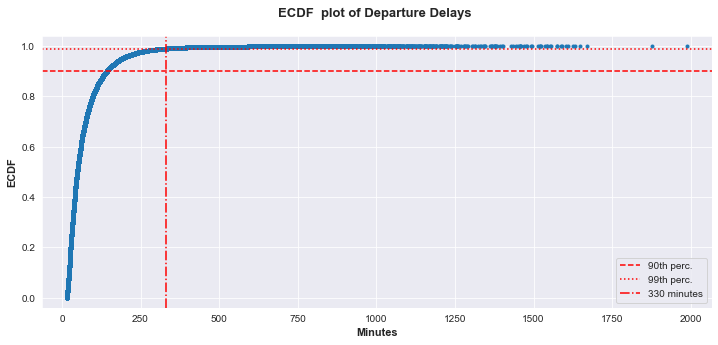

In [10]:
# create a ECDF (Empirical Cumulative Distribution Function) plot
plt.figure(figsize=(12,5))
x=np.sort(flights_DD['DEPARTURE_DELAY'])
y=np.arange(1, len(x)+1) / len(x)
_=plt.plot(x,y, marker='.', linestyle='none')
_=plt.xlabel('Minutes', fontsize=11, fontweight='bold')
_=plt.ylabel('ECDF', fontsize=11, fontweight='bold')
plt.title('ECDF  plot of Departure Delays \n', fontsize=13, fontweight='bold')
plt.margins(0.04) #buffer asround the edge
plt.axhline(y=0.90, color='r', linestyle = '--', label='90th perc.')
plt.axhline(y=0.99, color='r', linestyle = 'dotted', label='99th perc.')

#p99 is 330 minutes
plt.axvline(x=330, color='r', linestyle = 'dashdot', label='330 minutes')
plt.legend()

#####  Linear regression model

###### The variables

<AxesSubplot:>

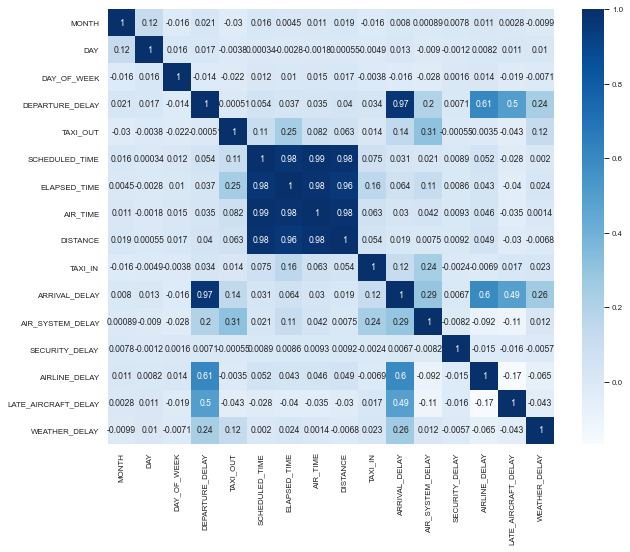

In [11]:
#create a heatmap to indentify the variables that corelate and display the feature names
plt.figure(figsize=(10,8))
sns.set_context('paper',font_scale=0.9)
flights_mx=flights_DD.corr()
sns.heatmap(flights_mx, annot=True, cmap='Blues')

Text(0, 0.5, '$R^{2}$')

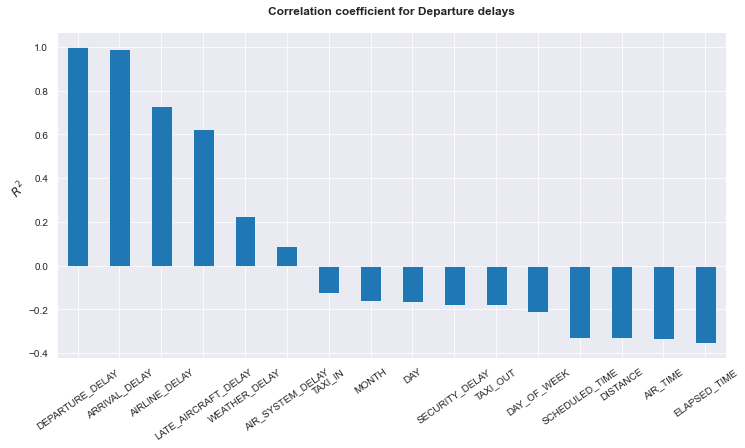

In [12]:
#create a barplot for correlated features
plt.figure(figsize=(12,6))
correlated_df=flights_mx.corr()
correlated_df=correlated_df.sort_values('DEPARTURE_DELAY', ascending=False)
correlated_df['DEPARTURE_DELAY'].plot(kind='bar', fontsize=10)
plt.xticks(rotation=35)
plt.title('Correlation coefficient for Departure delays\n',size=12, fontweight='bold')
plt.ylabel('$R^{2}$',size=12, fontweight='bold', rotation=45)

###### Multivariate linear regression model with statsmodel - Overall, all-data MODEL

In [13]:
#create a df with independent variables
independent_vrb=flights_DD[['MONTH','AIRLINE_DELAY',
                    'LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]

#create a df with the dependent variables
dependent_vrb=flights_DD[['DEPARTURE_DELAY']]

In [14]:
#add a constant to your Independent Dataframe to account for bias in the model
independent_vrb=sm.add_constant(independent_vrb)

In [15]:
# store and fit model
regression_model1=sm.OLS(dependent_vrb, independent_vrb).fit()
regression_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 1.114e+06
Date:                Sun, 03 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:44:19   Log-Likelihood:            -3.8739e+06
No. Observations:              819621   AIC:                         7.748e+06
Df Residuals:                  819616   BIC:                         7.748e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  14.4632      0.068    211.259      0.000      14.329      14.597
MONTH                   0.2748      0.009     30.855      0.000       0.257       0.292
AIRLINE_DELAY           0.9486      0.001   1664.082      0.000       0.947       0.950
LATE_AIRCRAFT_DELAY     0.9378      0.001   1444.473      0.000       0.937       0.939
WEATHER_DELAY           0.9348      0.001    715.792      0.000       0.932       0.937
==============================================================================
Omnibus:                  1053858.440   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        297185900.346
Skew:                           7.041   Prob(JB):                         0.00
Kurtosis:                      95.216   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(-0.4, 1.0)

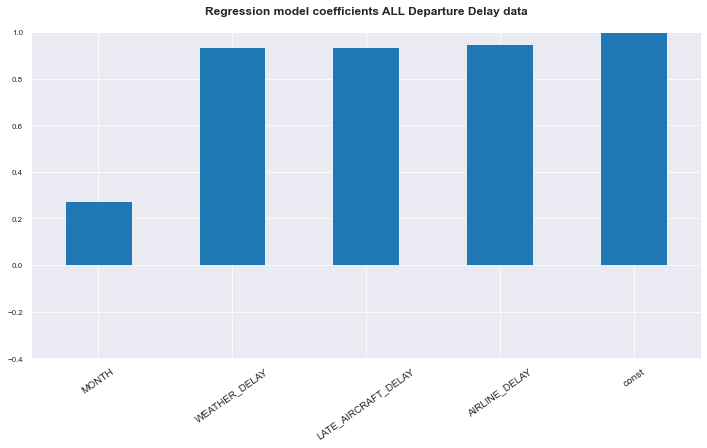

In [16]:
# analyzing the coefficients
plt.figure(figsize=(12,6))
regression_model1.params
regression_model1.params.sort_values().plot(kind='bar')
plt.title('Regression model coefficients ALL Departure Delay data\n',size=12, fontweight='bold')
plt.xticks(rotation=35, fontsize=10)
plt.ylim(-0.4,1)

###### Validate predictions - Scatter plot

In [17]:
#create a column for predicted values
flights_DD['DD_Prediction_1']=regression_model1.predict(independent_vrb)

Text(0.5, 1.0, 'Departure Delays: Actual vs. DD_Prediction\n')

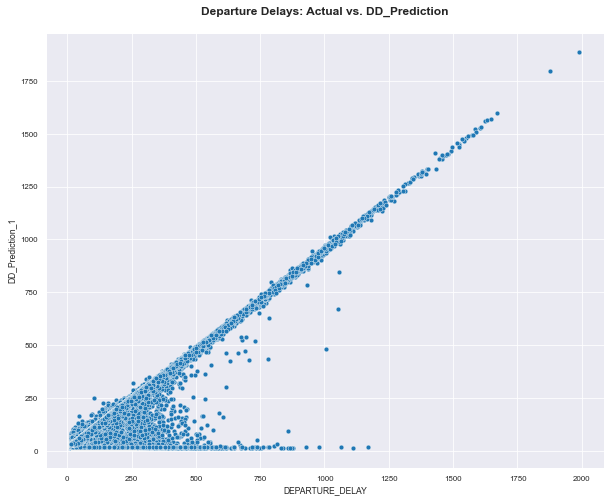

In [18]:
# cross plot between predicted and actual values
plt.figure(figsize=(10,8))
sns.scatterplot(x='DEPARTURE_DELAY', y='DD_Prediction_1', data=flights_DD)
plt.title('Departure Delays: Actual vs. DD_Prediction\n',size=12, fontweight='bold')

###### OLS get predictions

In [19]:
predictions = regression_model1.get_prediction()
df_predictions=predictions.summary_frame(alpha=0.05)
df_predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
30,14.74,0.06,14.62,14.86,-38.80,68.28
52,95.37,0.07,95.23,95.50,41.83,148.90
55,83.03,0.06,82.91,83.16,29.50,136.57
70,110.09,0.14,109.81,110.36,56.55,163.62
73,71.65,0.06,71.53,71.77,18.11,125.19
...,...,...,...,...,...,...
5819011,59.50,0.06,59.37,59.62,5.96,113.03
5819023,36.70,0.06,36.58,36.82,-16.84,90.24
5819051,32.94,0.06,32.81,33.06,-20.60,86.48
5819069,168.58,0.10,168.39,168.77,115.04,222.12


<AxesSubplot:xlabel='mean', ylabel='mean_se'>

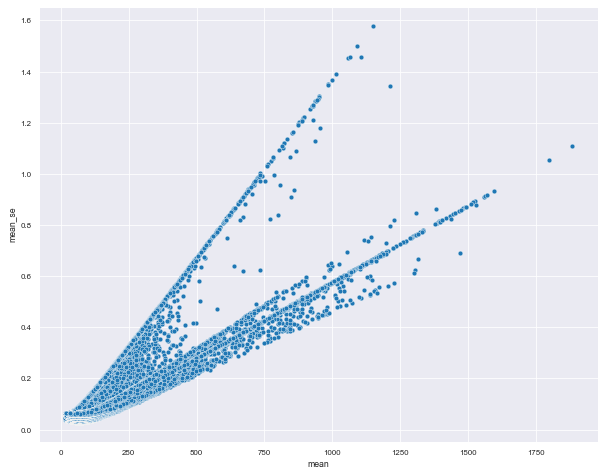

In [20]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='mean', y='mean_se', data=df_predictions)

<AxesSubplot:xlabel='mean_ci_lower', ylabel='mean_ci_upper'>

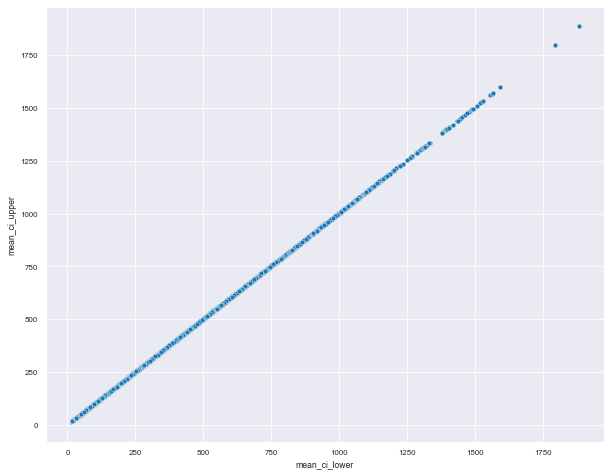

In [21]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='mean_ci_lower', y='mean_ci_upper', data=df_predictions)

<AxesSubplot:xlabel='obs_ci_lower', ylabel='obs_ci_upper'>

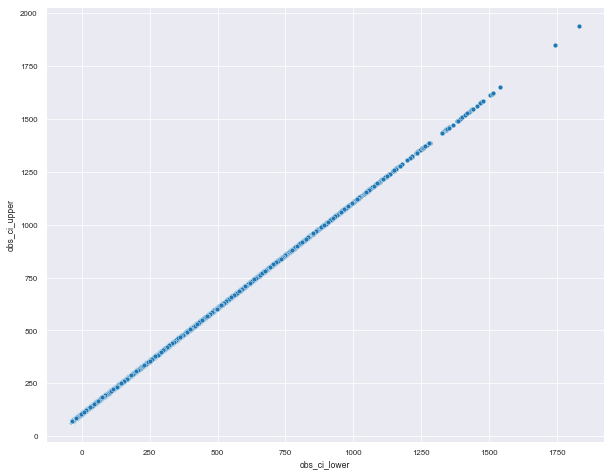

In [22]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='obs_ci_lower', y='obs_ci_upper', data=df_predictions)

In [23]:
pred_ols = regression_model1.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

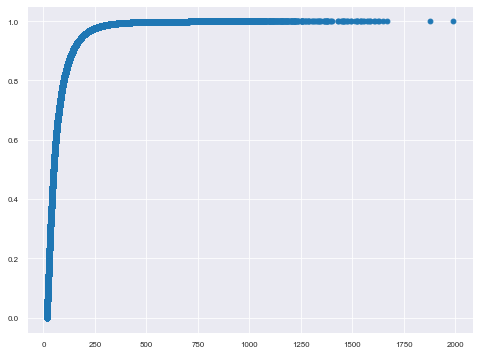

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="data")

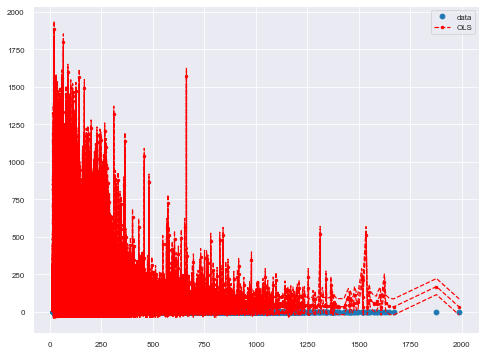

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="data")
ax.plot(x, regression_model1.fittedvalues, "r--.", label="OLS")
ax.plot(x, iv_u, "r--")
ax.plot(x, iv_l, "r--")
ax.legend(loc="best")

###### Model errors

In [26]:
regression_model1.mse_resid, regression_model1.mse_model, regression_model1.mse_total

(746.1422740777163, 831077428.7392342, 4802.054441164708)

In [27]:
#calculate MAE (Mean Absolute Error)

#calculate Absolute error
flights_DD['AE']=flights_DD['DD_Prediction_1']-flights_DD['DEPARTURE_DELAY']

#calculate MAE
MAE_model1=flights_DD['AE'].mean()
MAE_model1

-6.280339849155421e-15

In [28]:
#calculte mean absolute percentage error (MAPE),
#also known as mean absolutepercentage deviation (MAPD)
#is a measure of prediction accuracy of a forecasting method
#add new column
flights_DD['MAPE']=(flights_DD['DD_Prediction_1']-
                     flights_DD['DEPARTURE_DELAY'])/flights_DD['DEPARTURE_DELAY']

#calculate model accuracy
model1_accuracy=round((1-flights_DD['MAPE'].mean())*100,0)
model1_accuracy

87.0

In [29]:
#calculate MSE & add column 
flights_DD['MSE']=(flights_DD['DD_Prediction_1']-
                   flights_DD['DEPARTURE_DELAY'])**2
round(flights_DD['MSE'].mean(),0)

746.0

In [30]:
#calculate MSE & add column 
flights_DD['MSE']=(flights_DD['AE'])**2
round(flights_DD['MSE'].mean(),0)

746.0

In [31]:
RMSE_model1=flights_DD['MSE'].mean()**(1/2)
round(RMSE_model1,2)

27.32

In [32]:
# The performance measure depends on the difference between these two arrays
x = rmse(flights_DD['DEPARTURE_DELAY'], flights_DD['DD_Prediction_1'],axis=0)
round(x,2)

27.32

In [33]:
NRMS1=RMSE_model1/(flights_DD['DEPARTURE_DELAY'].max()-
                  flights_DD['DEPARTURE_DELAY'].min())
NRMS1

0.013851684400328761

####  <font color=blue>2. Departure Delay sub-datasets based on distribution values

##### Compare the distributions

In [34]:
# create a column  based on the 99 percentile corresponding to 330 minutes of delays
conditions=[(flights_DD['DEPARTURE_DELAY']<=330),
           (flights_DD['DEPARTURE_DELAY']>330)]
values=['DD_b330','DD_a330']

flights_DD['DD_330']=np.select(conditions, values)

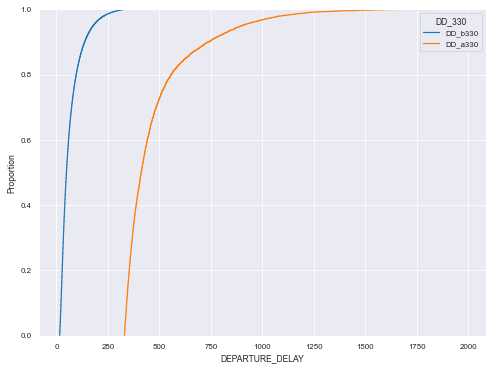

In [35]:
#compare the ECDF distributions for the 2 sub-datasets 
plt.figure(figsize=(8,6))
sns.ecdfplot(data=flights_DD,x='DEPARTURE_DELAY', hue='DD_330')
plt.margins(0.05)

<AxesSubplot:xlabel='DEPARTURE_DELAY', ylabel='DD_330'>

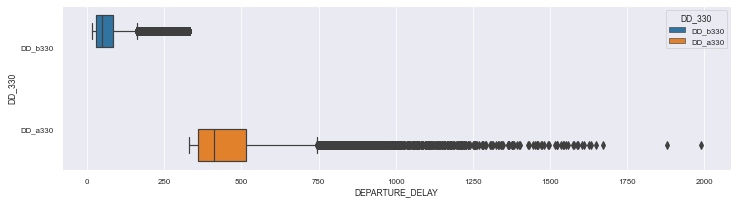

In [36]:
#compare the boxplot distributions for the 2 sub-datasets 
plt.figure(figsize=(12,3))
sns.boxplot(data=flights_DD, x='DEPARTURE_DELAY', y='DD_330', hue='DD_330')

In [37]:
#create a df for delays <=330' (99% of the raw data)
flights_DD_b330=flights_DD[flights_DD['DEPARTURE_DELAY']<=330]

In [38]:
# create df for delays >330' (99% of the raw data)
flights_DD_a330=flights_DD[flights_DD['DEPARTURE_DELAY']>330]

Text(0.5, 1.0, 'ECDF  plot of Departure Delays <=330 min.\n')

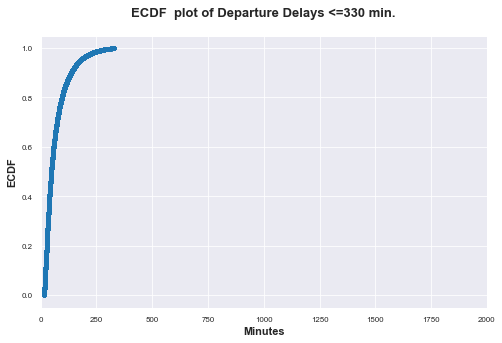

In [39]:
plt.figure(figsize=(8,5))
x=np.sort(flights_DD_b330['DEPARTURE_DELAY'])
y=np.arange(1, len(x)+1) / len(x)
plt.xlim(0,2000)
_=plt.plot(x,y, marker='.', linestyle='none')
_=plt.xlabel('Minutes', fontsize=11, fontweight='bold')
_=plt.ylabel('ECDF', fontsize=11, fontweight='bold')
plt.title('ECDF  plot of Departure Delays <=330 min.\n', fontsize=13, fontweight='bold')

Text(0.5, 1.0, 'ECDF  plot of Departure Delays>330 min. \n')

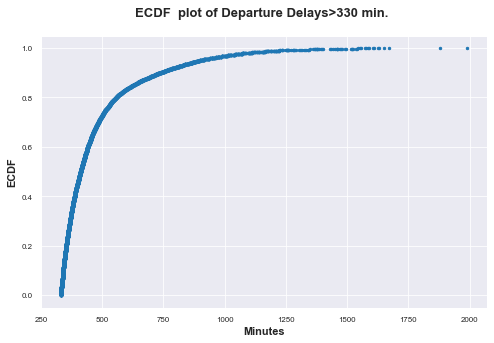

In [40]:
plt.figure(figsize=(8,5))
x=np.sort(flights_DD_a330['DEPARTURE_DELAY'])
y=np.arange(1, len(x)+1) / len(x)
_=plt.plot(x,y, marker='.', linestyle='none')
_=plt.xlabel('Minutes', fontsize=11, fontweight='bold')
_=plt.ylabel('ECDF', fontsize=11, fontweight='bold')
plt.title('ECDF  plot of Departure Delays>330 min. \n', fontsize=13, fontweight='bold')

#####  Departure Delays <=330' (99% of the data)

######  Linear regression model

###### The variables

<AxesSubplot:>

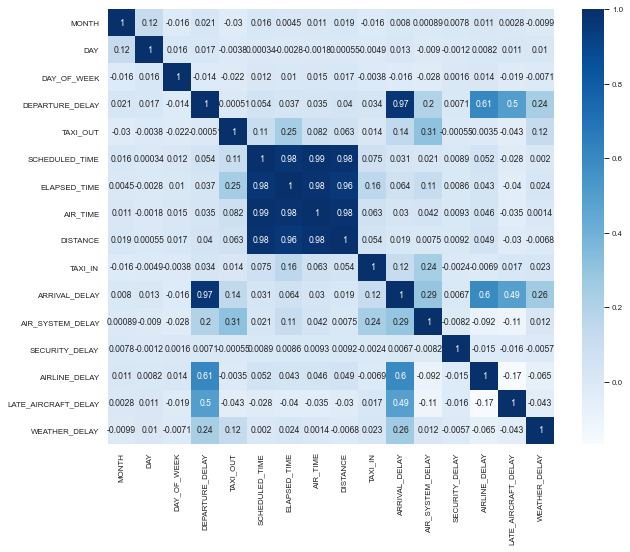

In [41]:
#create a heatmap to indentify the variables that corelate and display the feature names
plt.figure(figsize=(10,8))
sns.set_context('paper',font_scale=0.9)
flights_mx2=flights_DD_b330.corr()
sns.heatmap(flights_mx, annot=True, cmap='Blues')

Text(0, 0.5, '$R^{2}$')

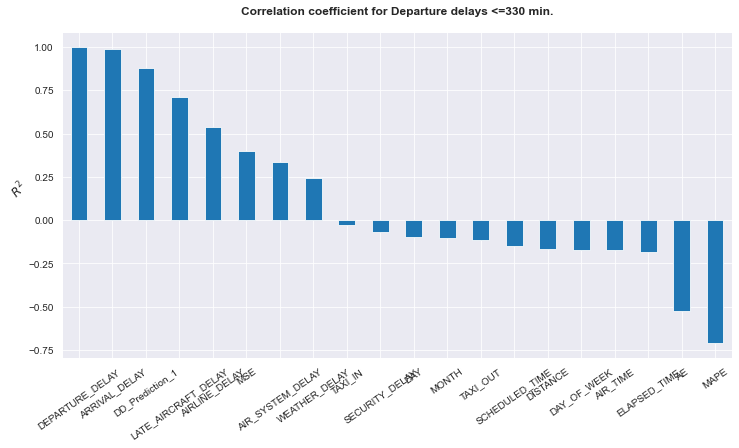

In [42]:
#create a barplot for correlated features
plt.figure(figsize=(12,6))
correlated_df=flights_mx2.corr()
correlated_df=correlated_df.sort_values('DEPARTURE_DELAY', ascending=False)
correlated_df['DEPARTURE_DELAY'].plot(kind='bar', fontsize=10)
plt.xticks(rotation=35)
plt.title('Correlation coefficient for Departure delays <=330 min.\n',size=12, fontweight='bold')
plt.ylabel('$R^{2}$',size=12, fontweight='bold', rotation=45)

###### Multivariate linear regression model

In [43]:
#create a df with independent variables
independent2_vrb=flights_DD_b330[['MONTH','AIRLINE_DELAY',
                    'LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]

#create a df with the dependent variables
dependent2_vrb=flights_DD_b330[['DEPARTURE_DELAY']]

In [44]:
#add a constant to your Independent Dataframe to account for bias in the model
independent2_vrb=sm.add_constant(independent2_vrb)

In [45]:
# store and fit model
regression_model2=sm.OLS(dependent2_vrb, independent2_vrb).fit()
regression_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                 7.253e+05
Date:                Sun, 03 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:44:36   Log-Likelihood:            -3.7482e+06
No. Observations:              811443   AIC:                         7.496e+06
Df Residuals:                  811438   BIC:                         7.496e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  15.8327      0.064    247.722      0.000      15.707      15.958
MONTH                   0.2624      0.008     32.625      0.000       0.247       0.278
AIRLINE_DELAY           0.9009      0.001   1222.109      0.000       0.899       0.902
LATE_AIRCRAFT_DELAY     0.9150      0.001   1386.030      0.000       0.914       0.916
WEATHER_DELAY           0.8931      0.002    590.455      0.000       0.890       0.896
==============================================================================
Omnibus:                   813839.335   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         46300724.524
Skew:                           5.027   Prob(JB):                         0.00
Kurtosis:                      38.614   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(-0.4, 1.0)

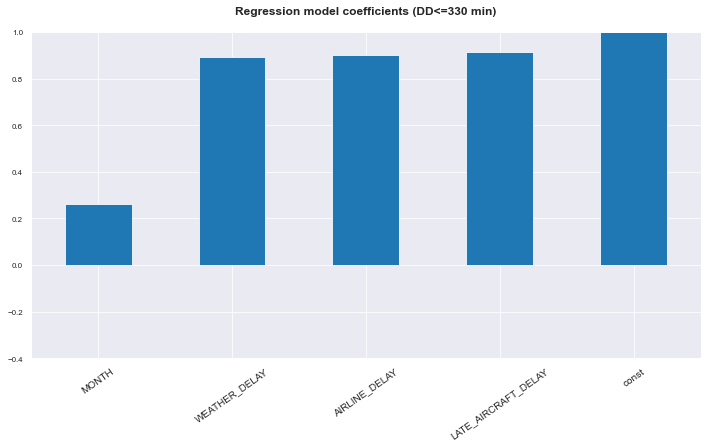

In [46]:
# analyzing the coefficients
plt.figure(figsize=(12,6))
regression_model2.params
regression_model2.params.sort_values().plot(kind='bar')
plt.title('Regression model coefficients (DD<=330 min)\n',size=12, fontweight='bold')
plt.xticks(rotation=35, fontsize=10)
plt.ylim(-0.4,1)

###### Validate predictions Scatter plot

In [47]:
flights_DD_b330['DD_Prediction_2']=regression_model2.predict(independent2_vrb)

Text(0.5, 1.0, 'Departure Delays: Actual vs. Prediction\n Delasy <=330 min.')

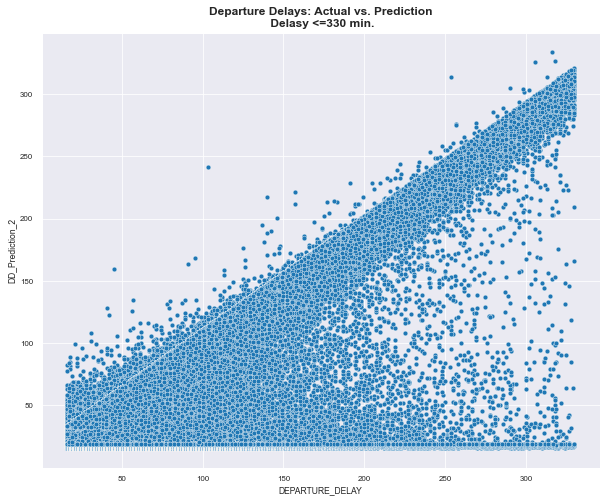

In [48]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='DEPARTURE_DELAY', y='DD_Prediction_2', data=flights_DD_b330)
plt.title('Departure Delays: Actual vs. Prediction\n Delasy <=330 min.',size=12, fontweight='bold')

###### OLS get predictions

In [49]:
predictions2 = regression_model2.get_prediction()
df_predictions2=predictions.summary_frame(alpha=0.05)
df_predictions2

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
30,14.74,0.06,14.62,14.86,-38.80,68.28
52,95.37,0.07,95.23,95.50,41.83,148.90
55,83.03,0.06,82.91,83.16,29.50,136.57
70,110.09,0.14,109.81,110.36,56.55,163.62
73,71.65,0.06,71.53,71.77,18.11,125.19
...,...,...,...,...,...,...
5819011,59.50,0.06,59.37,59.62,5.96,113.03
5819023,36.70,0.06,36.58,36.82,-16.84,90.24
5819051,32.94,0.06,32.81,33.06,-20.60,86.48
5819069,168.58,0.10,168.39,168.77,115.04,222.12


###### Model_2 errors

In [50]:
regression_model2.mse_resid, regression_model1.mse_model, regression_model1.mse_total

(602.0957261483068, 831077428.7392342, 4802.054441164708)

In [51]:
#calculate MAE (Mean Absolute Error)

#calculate Absolute error
flights_DD_b330['AE']=flights_DD_b330['DD_Prediction_2']-flights_DD_b330['DEPARTURE_DELAY']

#calculate MAE
MAE_model2=flights_DD_b330['AE'].mean()
MAE_model2

7.377077776353659e-14

In [52]:
#calculte mean absolute percentage error (MAPE),
#also known as mean absolutepercentage deviation (MAPD)
#is a measure of prediction accuracy of a forecasting method
#add new column
flights_DD_b330['MAPE']=(flights_DD_b330['DD_Prediction_2']-
                     flights_DD_b330['DEPARTURE_DELAY'])/flights_DD_b330['DEPARTURE_DELAY']
round(flights_DD_b330['MAPE'].mean(),2)

0.14

In [53]:
#calculate model accuracy
model2_accuracy=round((1-flights_DD_b330['MAPE'].mean())*100,0)
model2_accuracy

86.0

In [54]:
#calculate MSE & add column 
flights_DD_b330['MSE']=(flights_DD_b330['DD_Prediction_2']-
                   flights_DD_b330['DEPARTURE_DELAY'])**2
round(flights_DD_b330['MSE'].mean(),0)

602.0

In [55]:
RMSE_model2=flights_DD_b330['MSE'].mean()**(1/2)
round(RMSE_model2,2)

24.54

In [56]:
round(rmse(flights_DD_b330['DEPARTURE_DELAY'], flights_DD_b330['DD_Prediction_2'],axis=0),2)

24.54

#####  Departure Delays >330'

######  Linear regression model

###### The variables

<AxesSubplot:>

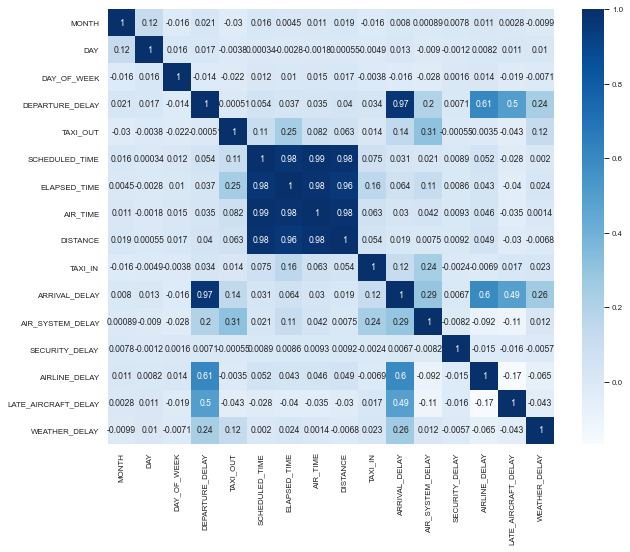

In [57]:
#create a heatmap to indentify the variables that corelate and display the feature names
plt.figure(figsize=(10,8))
sns.set_context('paper',font_scale=0.9)
flights_mx3=flights_DD_a330.corr()
sns.heatmap(flights_mx, annot=True, cmap='Blues')

Text(0, 0.5, '$R^{2}$')

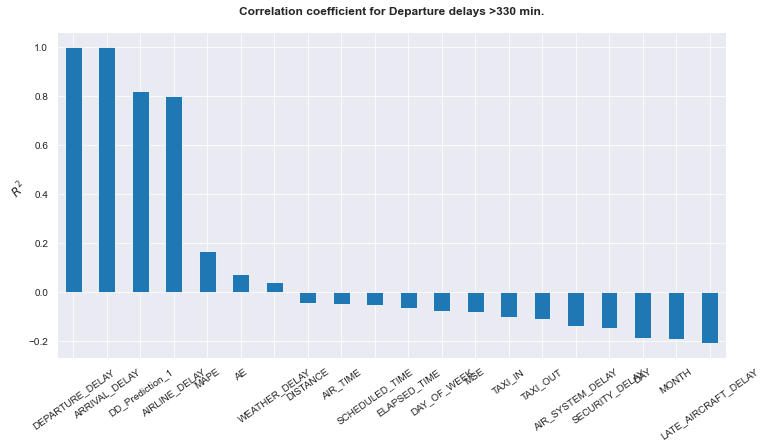

In [58]:
#create a barplot for correlated features
plt.figure(figsize=(12,6))
correlated_df=flights_mx3.corr()
correlated_df=correlated_df.sort_values('DEPARTURE_DELAY', ascending=False)
correlated_df['DEPARTURE_DELAY'].plot(kind='bar', fontsize=10)
plt.xticks(rotation=35)
plt.title('Correlation coefficient for Departure delays >330 min.\n',size=12, fontweight='bold')
plt.ylabel('$R^{2}$',size=12, fontweight='bold', rotation=45)

###### Multivariate linear regression model

In [59]:
#create a df with independent variables
independent3_vrb=flights_DD_a330[['MONTH','AIRLINE_DELAY',
                    'LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]

#create a df with the dependent variables
dependent3_vrb=flights_DD_a330[['DEPARTURE_DELAY']]

In [60]:
#add a constant to your Independent Dataframe to account for bias in the model
independent3_vrb=sm.add_constant(independent3_vrb)

In [61]:
# store and fit model
regression_model3=sm.OLS(dependent3_vrb, independent3_vrb).fit()
regression_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     6006.
Date:                Sun, 03 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:44:40   Log-Likelihood:                -49013.
No. Observations:                8178   AIC:                         9.804e+04
Df Residuals:                    8173   BIC:                         9.807e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 171.1200      3.154     54.255      0.000     164.937     177.303
MONTH                  -0.3550      0.305     -1.163      0.245      -0.953       0.243
AIRLINE_DELAY           0.7376      0.005    153.703      0.000       0.728       0.747
LATE_AIRCRAFT_DELAY     0.6670      0.007     92.895      0.000       0.653       0.681
WEATHER_DELAY           0.7045      0.009     82.609      0.000       0.688       0.721
==============================================================================
Omnibus:                     5083.835   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59606.547
Skew:                           2.846   Prob(JB):                         0.00
Kurtosis:                      14.939   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(-0.4, 1.0)

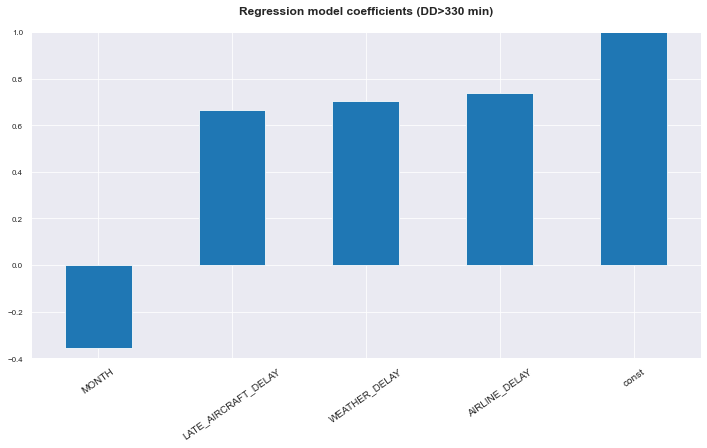

In [62]:
# analyzing the coefficients
plt.figure(figsize=(12,6))
regression_model3.params
regression_model3.params.sort_values().plot(kind='bar')
plt.title('Regression model coefficients (DD>330 min)\n',size=12, fontweight='bold')
plt.xticks(rotation=35, fontsize=10)
plt.ylim(-0.4,1)

###### Validate predictions - Scatter plot

In [63]:
flights_DD_a330['DD_Prediction_3']=regression_model3.predict(independent3_vrb)

Text(0.5, 1.0, 'Departure Delays: Actual vs. Prediction\n Delasy >30 min.')

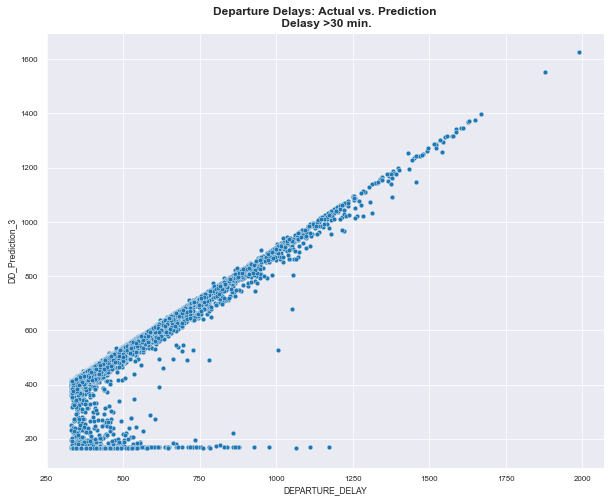

In [64]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='DEPARTURE_DELAY', y='DD_Prediction_3', data=flights_DD_a330)
plt.title('Departure Delays: Actual vs. Prediction\n Delasy >30 min.',size=12, fontweight='bold')

###### OLS get predictions

In [65]:
predictions3 = regression_model3.get_prediction()
df_predictions3=predictions.summary_frame(alpha=0.05)
df_predictions3

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
30,14.74,0.06,14.62,14.86,-38.80,68.28
52,95.37,0.07,95.23,95.50,41.83,148.90
55,83.03,0.06,82.91,83.16,29.50,136.57
70,110.09,0.14,109.81,110.36,56.55,163.62
73,71.65,0.06,71.53,71.77,18.11,125.19
...,...,...,...,...,...,...
5819011,59.50,0.06,59.37,59.62,5.96,113.03
5819023,36.70,0.06,36.58,36.82,-16.84,90.24
5819051,32.94,0.06,32.81,33.06,-20.60,86.48
5819069,168.58,0.10,168.39,168.77,115.04,222.12


###### Model_3 errors

In [66]:
regression_model3.mse_resid, regression_model1.mse_model, regression_model1.mse_total

(9408.3683383666, 831077428.7392342, 4802.054441164708)

In [67]:
#calculate MAE (Mean Absolute Error)

#calculate Absolute error
flights_DD_a330['AE']=flights_DD_a330['DD_Prediction_3']-flights_DD_a330['DEPARTURE_DELAY']

#calculate MAE
MAE_model3=flights_DD_a330['AE'].mean()
MAE_model3

5.67523637388862e-13

In [68]:
#calculte mean absolute percentage error (MAPE),
#also known as mean absolutepercentage deviation (MAPD)
#is a measure of prediction accuracy of a forecasting method
#add new column
flights_DD_a330['MAPE']=(flights_DD_a330['DD_Prediction_3']-
                     flights_DD_a330['DEPARTURE_DELAY'])/flights_DD_a330['DEPARTURE_DELAY']
round(flights_DD_a330['MAPE'].mean(),2)

0.03

In [69]:
#calculate model accuracy
model3_accuracy=round((1-flights_DD_a330['MAPE'].mean())*100,0)
model3_accuracy

97.0

In [70]:
#calculate MSE & add column 
flights_DD_a330['MSE']=(flights_DD_a330['DD_Prediction_3']-
                   flights_DD_a330['DEPARTURE_DELAY'])**2
round(flights_DD_a330['MSE'].mean(),0)

9403.0

In [71]:
RMSE_model3=flights_DD_a330['MSE'].mean()**(1/2)
round(RMSE_model3,2)

96.97

In [72]:
round(rmse(flights_DD_a330['DEPARTURE_DELAY'], flights_DD_a330['DD_Prediction_3'],axis=0),2)

96.97